# Electricity Demand Forecasting

## <table id='Table_Of_Contents'>Table Of Contents</table>

1. [Import Modules](#import)<br>
2. [Read Data File](#read_data)<br>
    1. [Clean Data Frame](#clean_data)<br>
    2. [Data Split](#data_split)<br>




### <a id='import'> 1. Import Modules</a>

In [1]:
import pandas as pd
import numpy as np
import re

import json
import datetime


from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler

#from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse


import warnings

from dateutil import parser

import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.statespace.mlemodel

### 2. Data Import <a id='read_data'></a>

In [2]:
data_file = '../data/big_demand_temp.csv'

In [3]:
full_df = pd.read_csv(data_file, index_col=0)

#### 2.A Clean the data frame <a id='clean_data'></a>

In [4]:
# Convert the time string to a datetime object
dt_time = [parser.isoparse(x) for x in full_df.loc[:, 'time']]
full_df.index = pd.DatetimeIndex(dt_time)
full_df.drop('time', axis=1, inplace=True)
full_df.sort_index(inplace=True)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41114 entries, 2015-07-01 08:00:00+00:00 to 2020-03-09 14:00:00+00:00
Data columns (total 8 columns):
demand           41114 non-null int64
Los Angeles      41114 non-null float64
San Diego        41114 non-null float64
San Jose         41114 non-null float64
San Francisco    41114 non-null float64
Sacramento       41114 non-null float64
Fresno           41114 non-null float64
CA_pop           41114 non-null float64
dtypes: float64(7), int64(1)
memory usage: 2.8 MB


In [5]:
full_df.head()

,demand,Los Angeles,San Diego,San Jose,San Francisco,Sacramento,Fresno,CA_pop
2015-07-01 08:00:00+00:00,38210,71.60,68.76,70.89,59.32,79.80,86.04,13845790.0
2015-07-01 09:00:00+00:00,35171,70.93,68.19,69.78,58.96,77.77,86.35,13845790.0
2015-07-01 10:00:00+00:00,33243,70.43,68.29,68.07,58.63,76.51,82.74,13845790.0
2015-07-01 11:00:00+00:00,31955,70.87,68.32,66.92,58.11,74.94,82.04,13845790.0
2015-07-01 12:00:00+00:00,31199,71.58,68.46,66.16,57.90,73.80,80.37,13845790.0


#### Extending Exogenous Regressors To Include Day Of Week

In [6]:
days = [x.weekday() for x in full_df.index]
days_df = pd.get_dummies(days)
days_df.columns=['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
days_df['DOW'] = days
days_df.index = full_df.index
new_df = pd.concat([full_df, days_df], axis=1)
col_names = []
col_names.extend(full_df.columns)
col_names.extend(days_df.columns)
new_df.columns = col_names
new_df.head()

,demand,Los Angeles,San Diego,San Jose,San Francisco,Sacramento,Fresno,CA_pop,Mon,Tue,Wed,Thur,Fri,Sat,Sun,DOW
2015-07-01 08:00:00+00:00,38210,71.60,68.76,70.89,59.32,79.80,86.04,13845790.0,0,0,1,0,0,0,0,2
2015-07-01 09:00:00+00:00,35171,70.93,68.19,69.78,58.96,77.77,86.35,13845790.0,0,0,1,0,0,0,0,2
2015-07-01 10:00:00+00:00,33243,70.43,68.29,68.07,58.63,76.51,82.74,13845790.0,0,0,1,0,0,0,0,2
2015-07-01 11:00:00+00:00,31955,70.87,68.32,66.92,58.11,74.94,82.04,13845790.0,0,0,1,0,0,0,0,2
2015-07-01 12:00:00+00:00,31199,71.58,68.46,66.16,57.90,73.80,80.37,13845790.0,0,0,1,0,0,0,0,2


#### 2.B Data Split <a id='data_split'></a>

In [7]:
# Split the data into training and test sections
data_len = new_df.shape[0]

In [8]:
# Split the data frame into two parts
train_len = int(0.5 * data_len)
window_len = int(0.1 * data_len)
validation_len = int(0.8 * data_len)

In [9]:
# Future notebooks will work better if we split the dataset at the beginning of the week
print(new_df.index[validation_len])
# work backward throug the list until we find DOW == 6
for idx, date in enumerate(new_df.index[validation_len::-1]) :
    if new_df.loc[date, 'DOW'] == 6 :
        break

validation_len = validation_len - idx + 1

2019-04-02 00:00:00+00:00


In [10]:
# Make the primary train/validation split
X_train = new_df.iloc[:validation_len, :]
X_val = new_df.iloc[validation_len:, :]


In [11]:
X_train.tail()

,demand,Los Angeles,San Diego,San Jose,San Francisco,Sacramento,Fresno,CA_pop,Mon,Tue,Wed,Thur,Fri,Sat,Sun,DOW
2019-03-31 19:00:00+00:00,21782,78.14,76.39,66.93,60.40,61.51,63.82,14173349.0,0,0,0,0,0,0,1,6
2019-03-31 20:00:00+00:00,21851,81.11,79.76,69.05,62.56,64.24,67.47,14173349.0,0,0,0,0,0,0,1,6
2019-03-31 21:00:00+00:00,21960,81.93,78.97,72.43,66.71,67.20,70.13,14173349.0,0,0,0,0,0,0,1,6
2019-03-31 22:00:00+00:00,22742,82.54,77.68,74.24,67.60,70.43,72.52,14173349.0,0,0,0,0,0,0,1,6
2019-03-31 23:00:00+00:00,23027,82.41,76.83,74.12,68.53,72.14,74.41,14173349.0,0,0,0,0,0,0,1,6


In [12]:
X_val.head()

,demand,Los Angeles,San Diego,San Jose,San Francisco,Sacramento,Fresno,CA_pop,Mon,Tue,Wed,Thur,Fri,Sat,Sun,DOW
2019-04-01 00:00:00+00:00,24233,81.03,76.26,73.87,65.30,73.42,75.23,14173349.0,1,0,0,0,0,0,0,0
2019-04-01 01:00:00+00:00,25377,77.71,73.92,71.25,62.63,73.58,74.98,14173349.0,1,0,0,0,0,0,0,0
2019-04-01 02:00:00+00:00,25263,74.85,71.90,68.08,60.05,73.29,73.82,14173349.0,1,0,0,0,0,0,0,0
2019-04-01 03:00:00+00:00,26855,71.74,70.20,64.87,58.02,64.46,71.32,14173349.0,1,0,0,0,0,0,0,0
2019-04-01 04:00:00+00:00,26907,70.26,69.32,61.56,57.41,67.34,67.98,14173349.0,1,0,0,0,0,0,0,0


In [13]:
# Save the test data to a csv file
X_val.to_csv('../data/big_demand_temp_validation.csv')
X_train.to_csv('../data/big_demand_temp_train.csv')

In [14]:
# Make the primary train/validation split
X_train = new_df.iloc[:train_len, :]

# Make intermediate trail windows for walk forward validation
X_walk1 = new_df.iloc[train_len:train_len+window_len, :]
X_walk2 = new_df.iloc[train_len+window_len:train_len+2*window_len, :]
X_walk3 = new_df.iloc[train_len+2*window_len:train_len+3*window_len, :]

In [15]:
# Look at the dataframe contents
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20557 entries, 2015-07-01 08:00:00+00:00 to 2017-11-03 20:00:00+00:00
Data columns (total 16 columns):
demand           20557 non-null int64
Los Angeles      20557 non-null float64
San Diego        20557 non-null float64
San Jose         20557 non-null float64
San Francisco    20557 non-null float64
Sacramento       20557 non-null float64
Fresno           20557 non-null float64
CA_pop           20557 non-null float64
Mon              20557 non-null uint8
Tue              20557 non-null uint8
Wed              20557 non-null uint8
Thur             20557 non-null uint8
Fri              20557 non-null uint8
Sat              20557 non-null uint8
Sun              20557 non-null uint8
DOW              20557 non-null int64
dtypes: float64(7), int64(2), uint8(7)
memory usage: 1.7 MB


### 3. Helper Functions <a id='helper'></a>

In [16]:
# This funtion tests the stationarity of the data set
#   The function was originally published as part of the Blog post
#
#   https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba
#
#
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

### 4. Data Analysis <a id='analysis'></a>

No handles with labels found to put in legend.
/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


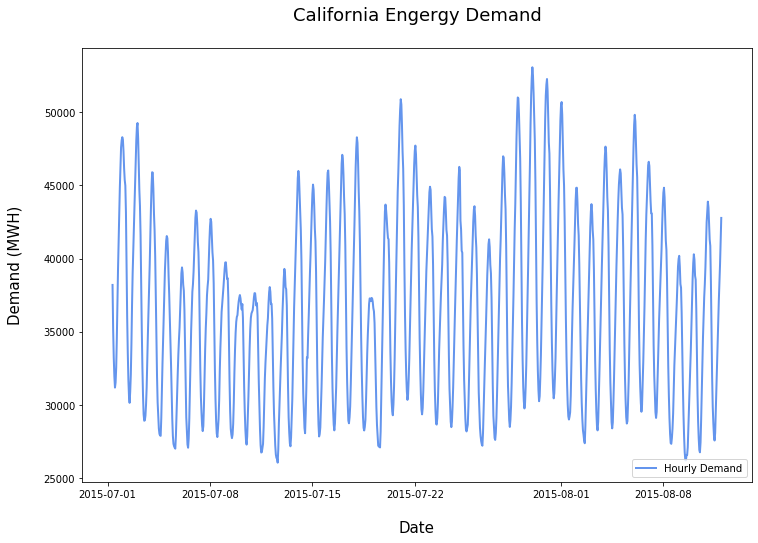

In [17]:
fig = plt.figure(figsize=[12, 8])
fig.patch.set_alpha(0.0)
fig.patch.set_facecolor(None)

ax = fig.add_subplot(1,1,1)
ax.patch.set_visible(False)
ax.set_alpha(0.0)

plt.plot(facecolor=('#000000'), alpha=0.0)


plt.title('California Engergy Demand\n', fontsize=18)
plt.xlabel('\nDate', fontsize=15)
plt.ylabel('Demand (MWH)\n', fontsize=15)
plt.legend(loc='lower right')

plt.plot(X_train.index[:1000], X_train['demand'].values[:1000], \
    c='cornflowerblue', label='Hourly Demand', linewidth=2)

plt.legend( loc='lower right')

plt.savefig('raw_demand_data.png', Transparent=True)

#### 4.1 Stationarity Testing <a id='stationarity'></a>

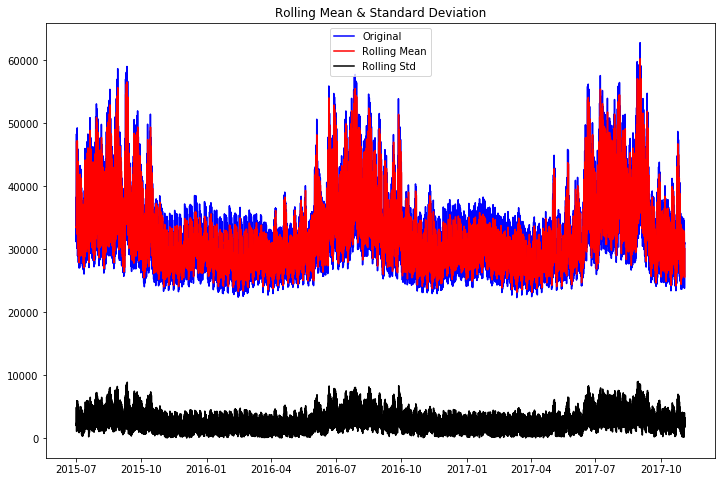

Results of Dickey-Fuller Test:
p-value = 0.0008. The series is likely stationary.
Test Statistic                    -4.142402
p-value                            0.000823
#Lags Used                        20.000000
Number of Observations Used    20536.000000
Critical Value (1%)               -3.430668
Critical Value (5%)               -2.861681
Critical Value (10%)              -2.566845
dtype: float64


In [18]:
test_stationarity(X_train.demand, window=8)

#### 4.2 Autocorrelation <a id='autocorr'></a>

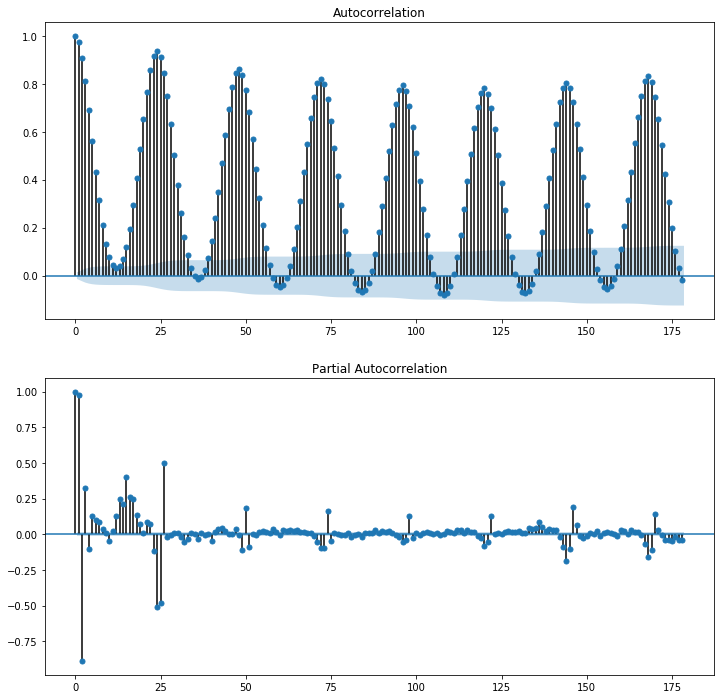

In [19]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X_train['demand'], lags=24*7+10, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(X_train['demand'], lags=24*7+10, ax=ax2)# , lags=40

#### 4.3 Seasonal Decomposition <a id='seasonal_decomp'></a>

In [20]:
# Do seasonal decopostion on the weekly periodic features
decomp_data = seasonal_decompose(X_train.demand, period=24, model='additive')

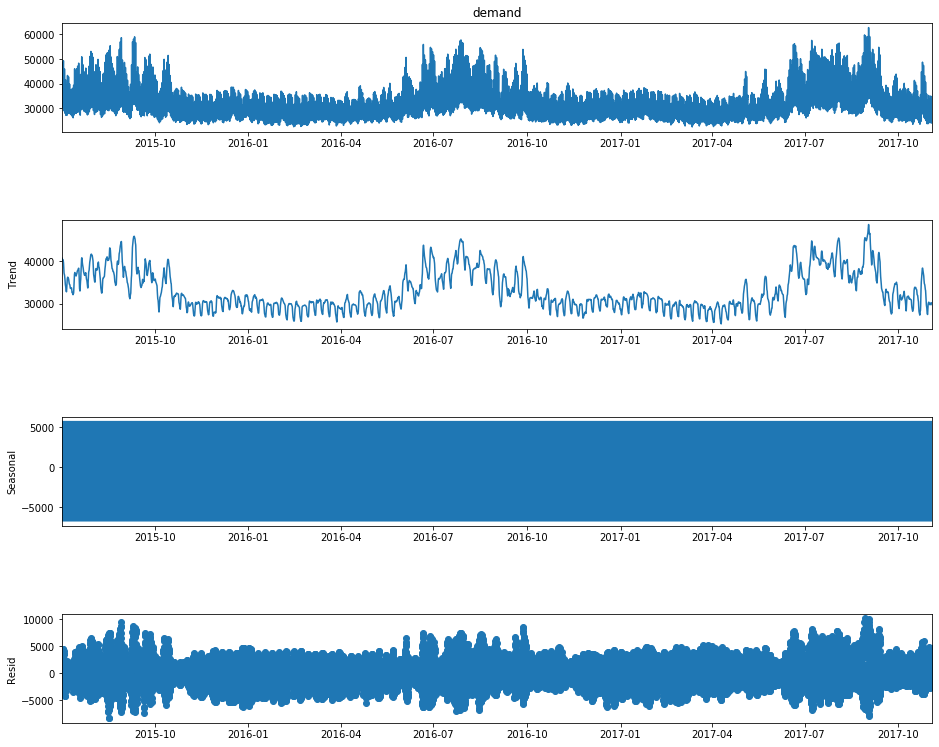

In [21]:
fig = decomp_data.plot()
fig.set_size_inches(15, 12)

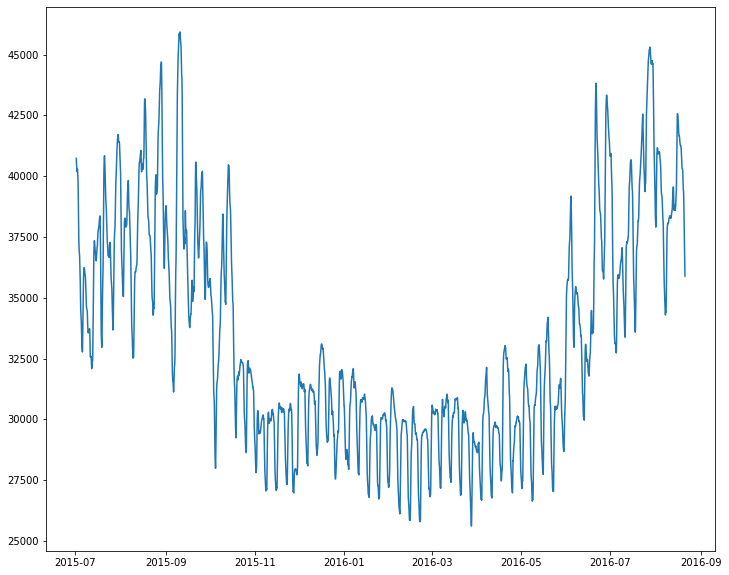

In [22]:
# Plot a closeup of the seasonal component
fig = plt.figure(figsize=[12,10])
plt.plot(decomp_data.trend[:10000])

#### 4.4 Trend Autocorrelation <a id='trend_auto'></a>

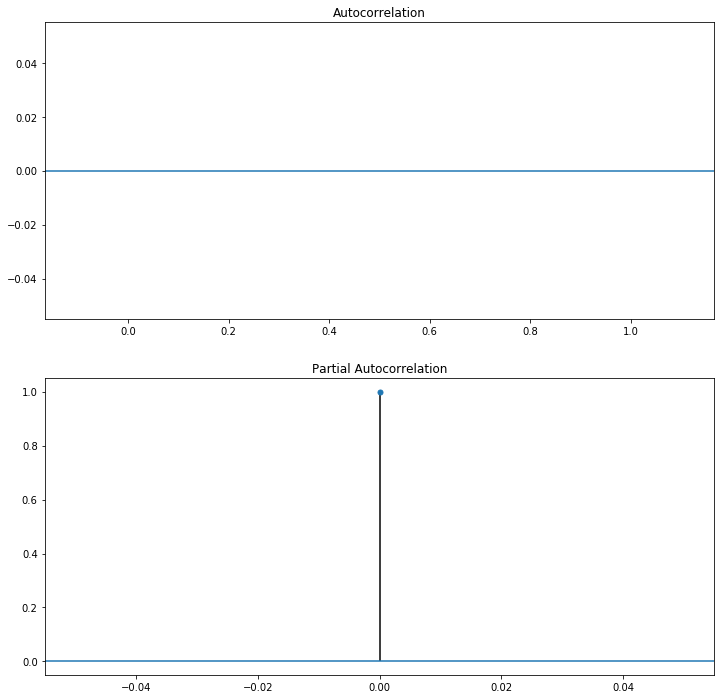

In [23]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(decomp_data.trend, lags=24*7+10, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(decomp_data.trend, lags=24*7+10, ax=ax2)

### Data Aggregation

For a useful forecast we want to predict the demand a week or two in advance.  Forecasting weeks in advance
can with hourly demand data can be challenging.  I will aggregate the data by day and week and save
new files for modeling explorations.

In [24]:
# drop all the rows before the start of the fisrt Monday
rows_to_drop = []
for row in X_train.index :
    if X_train.loc[row, 'DOW'] != 0:
        rows_to_drop.append(row)
    else:
        break
X_train.drop(rows_to_drop, inplace=True)

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [25]:
X_train.head()

,demand,Los Angeles,San Diego,San Jose,San Francisco,Sacramento,Fresno,CA_pop,Mon,Tue,Wed,Thur,Fri,Sat,Sun,DOW
2015-07-06 00:00:00+00:00,38071,74.17,69.43,78.25,66.18,90.49,95.83,13845790.0,1,0,0,0,0,0,0,0
2015-07-06 01:00:00+00:00,39010,72.28,68.51,75.94,64.31,84.75,95.64,13845790.0,1,0,0,0,0,0,0,0
2015-07-06 02:00:00+00:00,39405,70.25,67.70,74.14,62.92,81.56,94.93,13845790.0,1,0,0,0,0,0,0,0
2015-07-06 03:00:00+00:00,39064,67.59,66.97,69.65,62.28,77.68,93.31,13845790.0,1,0,0,0,0,0,0,0
2015-07-06 04:00:00+00:00,38220,65.97,66.65,65.95,61.45,73.51,89.89,13845790.0,1,0,0,0,0,0,0,0


In [32]:
# Aggregate data on a daily basis
def agg_daily(data_frame):
    current_day = X_train.index[0].date()
    day_demand = 0.0
    X_by_day = pd.DataFrame([], index=[current_day], \
        columns=['day_demand', 'CA_pop', 'la_high', 'sd_high', 'sj_high', 'sf_high',\
                 'sac_high', 'f_high', 'DOW' ])
    la_high = 0
    sd_high = 0
    f_high = 0
    sj_high = 0
    sf_high = 0
    sac_high = 0
    pop = 0

    for row in data_frame.index :
        next_day = row.date()
        if next_day != current_day :
            X_by_day.loc[current_day] = [day_demand, pop, la_high, sd_high, sj_high, sf_high, \
                        sac_high, f_high, current_day.weekday()]
            '''
            {'day_demand' :day_demand, 'la_high': la_high,\
                'sd_high' : sd_high, 'f_high' : f_high, 'DOW' : current_day.weekday()}
            '''
            current_day = next_day
            la_high = 0
            sd_high = 0
            sj_high = 0
            sf_high = 0
            sac_high = 0
            f_high = 0
            day_demand = 0
            pop=0
        else :
            day_demand += data_frame.loc[row, 'demand']
            pop = data_frame.loc[row, 'CA_pop']
            if data_frame.loc[row, 'Los Angeles'] > la_high :
                la_high = data_frame.loc[row, 'Los Angeles']
            if data_frame.loc[row, 'San Diego'] > sd_high :
                sd_high = data_frame.loc[row, 'San Diego']
            if data_frame.loc[row, 'Fresno'] > f_high :
                f_high = data_frame.loc[row, 'Fresno']
            if data_frame.loc[row, 'San Jose'] > sj_high :
                sj_high = data_frame.loc[row, 'San Jose']
            if data_frame.loc[row, 'San Francisco'] > sf_high :
                sf_high = data_frame.loc[row, 'San Francisco']
            if data_frame.loc[row, 'Sacramento'] > sac_high :
                sac_high = data_frame.loc[row, 'Sacramento']
    
    X_by_day.loc[current_day] = [day_demand, pop, la_high, sd_high, sj_high, sf_high, \
                sac_high, f_high, current_day.weekday()]
    
    return X_by_day

    

In [33]:
X_by_day = agg_daily(X_train)

In [34]:
X_by_day.head()

,day_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW
2015-07-06,834762,1.38458e+07,76.53,69.43,79.45,68.22,91.88,95.83,0
2015-07-07,825173,1.38458e+07,77.05,69.61,79.38,68.29,90.67,92.31,1
2015-07-08,804819,1.38458e+07,73.9,70.08,74.78,64.59,86.6,91.83,2
2015-07-09,782610,1.38458e+07,74.22,71.3,74,63.23,78.27,88.91,3
2015-07-10,769752,1.38458e+07,74.57,73.32,73.66,68.02,78.92,82.6,4


In [35]:
X_by_day.to_csv('../data/big_demand_temp_train_by_day.csv')

In [30]:
def agg_weekly(data_frame) :
    # Aggregate data on a weekly basis
    current_day = data_frame.index[0].date()
    row = data_frame.index[0]
    current_dow = data_frame.loc[row, 'DOW']
    week_demand = 0.0
    X_by_week = pd.DataFrame([], index=[current_day], \
        columns=['week_demand', 'CA_pop', 'la_high', 'sd_high', 'sj_high', 'sf_high',\
                 'sac_high', 'f_high', 'DOW' ])

    la_high = 0
    sd_high = 0
    f_high = 0
    sj_high = 0
    sf_high = 0
    sac_high = 0
    pop=0
    found_tue = False

    print(current_dow)
    for row in data_frame.index :
        next_dow = data_frame.loc[row].DOW
        if next_dow == 0 and found_tue == False :
            current_day = row.date()

        if next_dow == 1 :
            found_tue = 1

        if next_dow == 0 and found_tue :
            X_by_week.loc[current_day] = [week_demand, pop, \
                la_high, sd_high, sj_high, sf_high, sac_high, f_high, current_day.weekday()]
            '''
            {'day_demand' :day_demand, 'la_high': la_high,\
                'sd_high' : sd_high, 'f_high' : f_high, 'DOW' : current_day.weekday()}
            '''
            current_dow = next_dow
            found_tue = False
            la_high = 0
            sd_high = 0
            f_high = 0
            sj_high = 0
            sf_high = 0
            sac_high = 0
            pop=0
            week_demand = 0
        else :
            week_demand += data_frame.loc[row, 'demand']
            pop = data_frame.loc[row, 'CA_pop']
            if data_frame.loc[row, 'Los Angeles'] > la_high :
                la_high = data_frame.loc[row, 'Los Angeles']
            if data_frame.loc[row, 'San Diego'] > sd_high :
                sd_high = data_frame.loc[row, 'San Diego']
            if data_frame.loc[row, 'Fresno'] > f_high :
                f_high = data_frame.loc[row, 'Fresno']
            if data_frame.loc[row, 'San Francisco'] > sf_high :
                sf_high = data_frame.loc[row, 'San Francisco']
            if data_frame.loc[row, 'San Jose'] > sj_high :
                sj_high = data_frame.loc[row, 'San Jose']
            if data_frame.loc[row, 'Sacramento'] > sac_high :
                sac_high = data_frame.loc[row, 'Sacramento']
                
    X_by_week.loc[current_day] = [week_demand, pop, \
        la_high, sd_high, sj_high, sf_high, sac_high, f_high, current_day.weekday()]

                
    return X_by_week

In [31]:
X_train_weekly = agg_weekly(X_train)
X_train_weekly.head(), X_train_weekly.shape

0


(            week_demand       CA_pop la_high sd_high sj_high sf_high sac_high  \
 2015-07-06   5.7311e+06  1.38458e+07   82.21   73.78   79.45   70.22    93.37   
 2015-07-13  6.06742e+06  1.38458e+07   89.36   84.02   90.26   83.36    98.36   
 2015-07-20  6.23374e+06  1.38458e+07   87.65    80.5   88.28   78.39    98.36   
 2015-07-27  6.47330e+06  1.38458e+07   86.55    78.3   95.77    82.2   106.58   
 2015-08-03  6.16622e+06  1.38458e+07    91.7   81.52   83.53   70.89    95.65   
 
            f_high DOW  
 2015-07-06  95.83   0  
 2015-07-13   99.6   0  
 2015-07-20  98.03   0  
 2015-07-27  106.4   0  
 2015-08-03  95.56   0  , (122, 9))

In [32]:
X_train_weekly.to_csv('../data/big_demand_temp_train_by_week.csv')